### Model Selected Afinn

This model has an additional functionality to extract emotions, which could add value to the analysis. Also has incorporated the function "score" which give us a numeric scoring for each text according to the polarity, more positives words more puntuation.

In [2]:
pip install Afinn


  Created wheel for Afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=90a80b86e7bca0784bbb9331c3ff19c58bf7452a4547f59bd54010cd83fdfa7b
  Stored in directory: c:\users\usuario\appdata\local\pip\cache\wheels\79\91\ee\8374d9bc8c6c0896a2db75afdfd63d43653902407a0e76cd94
Successfully built Afinn
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install NRCLex

  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43339 sha256=3b64da2a1b8efb3cd2fc2bfff3cfb2a81bfa445f6d0fd7c6160c113d27d82e20
  Stored in directory: c:\users\usuario\appdata\local\pip\cache\wheels\68\c4\f2\c390dd3eac398fdf45f7a01c6516bc53fa7a9ab59c7d2ff518
Successfully built NRCLex
Note: you may need to restart the kernel to use updated packages.


In [4]:
from afinn import Afinn
import pandas as pd

from nrclex import NRCLex
import re
from tqdm import tqdm

from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
afinn = Afinn()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Read data
path = 'https://raw.githubusercontent.com/kmiloR2/Maestria/main/data-example-feedback%20v2.xlsx'
df = pd.read_excel(path)
df.head()

,Name,Position,Feedback,Date
0,Steve Rogers,Production Manager,"Steve is always available, trying to help as m...",2020-08-11
1,Steve Rogers,Production Manager,"Very approachable person, always willingness t...",2020-11-15
2,Steve Rogers,Production Manager,"Oriented to details, always trying to help oth...",2020-01-11
3,Thor Odinson,software Hybrid Developer,I saw that you learned how to use pivot tables...,2020-03-11
4,Thor Odinson,software Hybrid Developer,I can’t help but notice that this is the third...,2020-03-11


In [7]:
# Remove punctuation and stop words

def preprocess_text(text_data):
   
    punctuation = re.compile(r'[^\w\s]')
    
    english_stopwords = set(stopwords.words('english'))
  
    preprocessed_text = []
    for sentence in tqdm(text_data):
        # Converting lowercase
        sentence = sentence.lower()
        
        # Removing punctuations
        sentence = punctuation.sub('', sentence)
  
        # Removing stopwords and tokenizing
        preprocessed_text.append(' '.join(token for token in nltk.word_tokenize(sentence) if token not in english_stopwords))
  
    return preprocessed_text 

#Count emotions frequency
def obtener_valores(emociones):
    valores_emociones = {}
    emociones_deseadas = ['anticipation', 'fear', 'joy', 'positive', 'trust', 'anger', 'negative', 'sadness', 'surprise']

    for emocion in emociones_deseadas:
        if emocion in emociones:
            valores_emociones[emocion] = emociones[emocion]
        else:
            valores_emociones[emocion] = None
    
    return pd.Series(valores_emociones)

In [8]:
##PREPROCESADO


#fill na
df['Feedback'] = df['Feedback'].fillna('')

# preprocess text /remove stop words, punctuation, lower case
preprocessed_review = preprocess_text(df['Feedback'].values)
df['Feedback'] = preprocessed_review

#apply afinn score and polarity
df['sentiment_score'] = df['Feedback'].apply(lambda x: afinn.score(x))

scores = df['sentiment_score']
sentiment = ['positive' if score >= 0
                          else 'negative' 
                                  for score in scores]
df['sentiments'] = sentiment

# calculate emotion scores
df['raw_emotion_scores'] = df['Feedback'].apply(lambda x: NRCLex(x).raw_emotion_scores)

#create emotions frequency columns
df[['anticipation','fear','joy','positive','trust', 'anger','negative','sadness', 'surprise']] = df['raw_emotion_scores'].apply(lambda x: pd.Series(obtener_valores(x)))



100%|██████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 1738.86it/s]


In [9]:
df.head()

,Name,Position,Feedback,Date,sentiment_score,sentiments,raw_emotion_scores,anticipation,fear,joy,positive,trust,anger,negative,sadness,surprise
0,Steve Rogers,Production Manager,steve always available trying help much possib...,2020-08-11,16.0,positive,"{'anticipation': 4, 'joy': 5, 'positive': 5, '...",4.0,NaN,5.0,5.0,5.0,NaN,NaN,NaN,2.0
1,Steve Rogers,Production Manager,approachable person always willingness help co...,2020-11-15,7.0,positive,"{'positive': 2, 'anticipation': 1, 'joy': 1, '...",1.0,NaN,1.0,2.0,2.0,NaN,NaN,NaN,1.0
2,Steve Rogers,Production Manager,oriented details always trying help others nic...,2020-01-11,5.0,positive,{'positive': 1},NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,Thor Odinson,software Hybrid Developer,saw learned use pivot tables excel project rea...,2020-03-11,6.0,positive,"{'positive': 4, 'trust': 2, 'anticipation': 2,...",2.0,NaN,1.0,4.0,2.0,NaN,1.0,NaN,1.0
4,Thor Odinson,software Hybrid Developer,cant help notice third deadline thats caught m...,2020-03-11,4.0,positive,"{'positive': 2, 'trust': 2, 'anticipation': 1}",1.0,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN


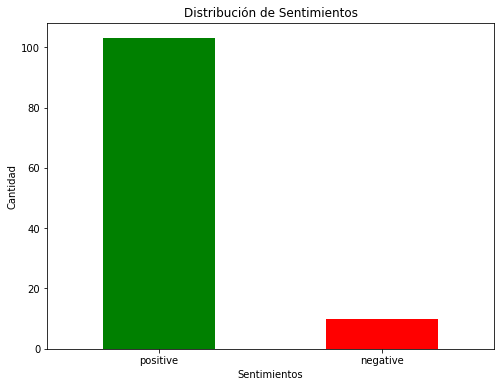

In [16]:
import matplotlib.pyplot as plt 

sentiment_graph = df['sentiments'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
sentiment_graph.plot(kind='bar', color=['green', 'red'])
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimientos')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)  # Evita la rotación de las etiquetas en el eje x
plt.show()



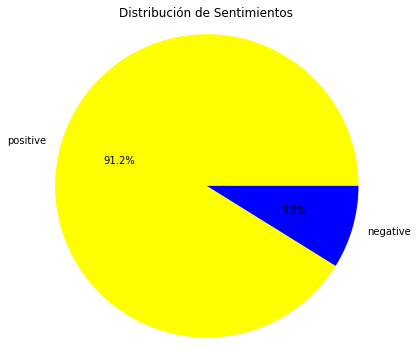

In [17]:
sentiment_graph2 = df['sentiments'].value_counts()


plt.figure(figsize=(6, 6))
plt.pie(sentiment_graph2, labels=sentiment_graph2.index, autopct='%1.1f%%', colors=['yellow', 'blue'])
plt.title('Distribución de Sentimientos')
plt.axis('equal')  # Para asegurarse de que el gráfico sea circular
plt.show()

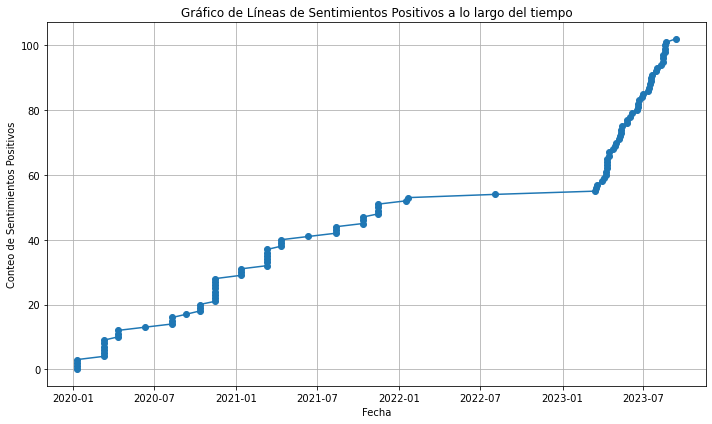

In [18]:
df_filtered = df[df['sentiments'] == 'positive']

df_filtered = df_filtered.sort_values(by='Date')

plt.figure(figsize=(10, 6))
plt.plot(df_filtered['Date'], range(len(df_filtered)), marker='o', linestyle='-')
plt.title('Gráfico de Líneas de Sentimientos Positivos a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Conteo de Sentimientos Positivos')
plt.grid(True)


plt.tight_layout()
plt.show()

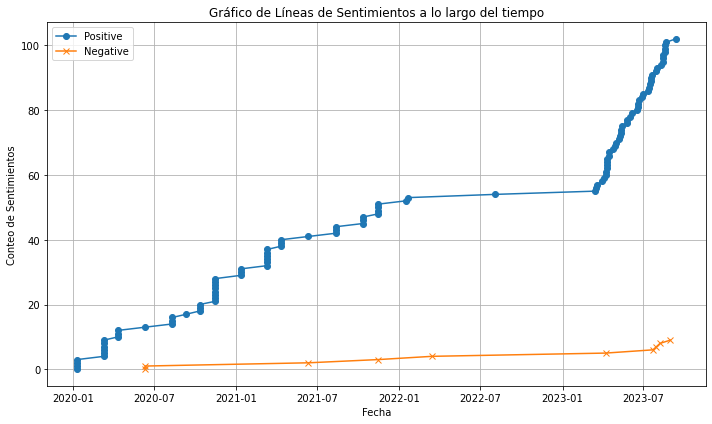

In [19]:
#chatpgt credits
df_positive = df[df['sentiments'] == 'positive']

df_negative = df[df['sentiments'] == 'negative']

df_positive = df_positive.sort_values(by='Date')
df_negative = df_negative.sort_values(by='Date')

plt.figure(figsize=(10, 6))
plt.plot(df_positive['Date'], range(len(df_positive)), marker='o', linestyle='-', label='Positive')
plt.plot(df_negative['Date'], range(len(df_negative)), marker='x', linestyle='-', label='Negative')
plt.title('Gráfico de Líneas de Sentimientos a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Conteo de Sentimientos')
plt.grid(True)

plt.legend()

plt.tight_layout()
plt.show()

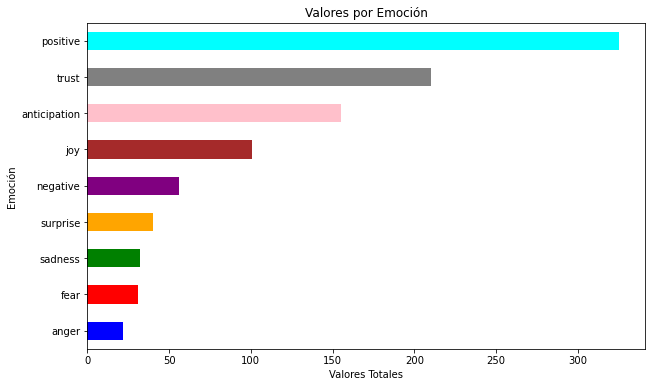

In [23]:
emotions = df[['anticipation', 'fear', 'joy', 'positive', 'trust', 'anger', 'negative', 'sadness', 'surprise']].sum()

colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan']
emotions = emotions.sort_values()

emotions.plot(kind='barh', figsize=(10, 6), color=colors)
plt.title('Valores por Emoción')
plt.ylabel('Emoción')
plt.xlabel('Valores Totales')
plt.show()

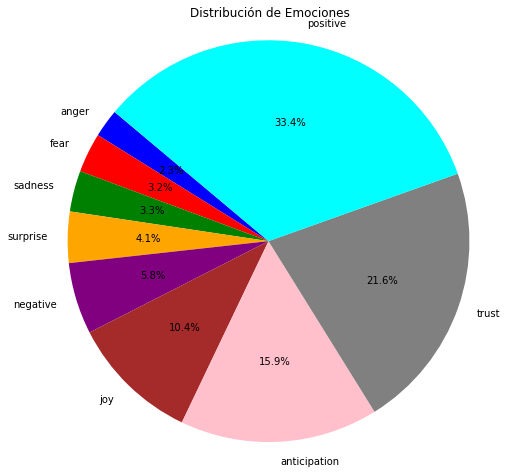

In [24]:

plt.figure(figsize=(8, 8))
plt.pie(emotions, labels=emotions.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Emociones')
plt.axis('equal')  # Proporciona un círculo perfecto

plt.show()

In [25]:
groupby_df = df.groupby('Date').agg({'sentiment_score': 'mean'}).reset_index()

groupby_df = groupby_df.rename(columns={'sentiment_score': 'Mean_sentiment_score'})

groupby_df

,Date,Mean_sentiment_score
0,2020-01-11,6.750000
1,2020-03-11,4.666667
2,2020-04-11,5.333333
3,2020-06-11,0.333333
4,2020-08-11,8.333333
...,...,...
58,2023-08-14,12.000000
59,2023-08-19,6.333333
60,2023-08-21,8.000000
61,2023-08-30,-3.000000


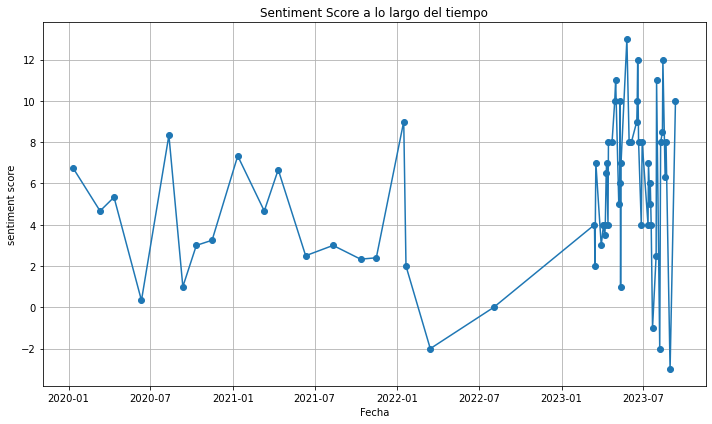

In [26]:

plt.figure(figsize=(10, 6))
plt.plot(groupby_df['Date'], groupby_df['Mean_sentiment_score'], marker='o', linestyle='-')
plt.title('Sentiment Score a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('sentiment score')
plt.grid(True)


plt.tight_layout()
plt.show()